# Importing Libraries & loading data

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import calendar
import pickle

# Checking the data for null values

In [85]:
parent_df = pd.read_csv("/content/monatszahlen2412_verkehrsunfaelle_06_12_24.csv")


In [86]:
print(parent_df.info())
print(parent_df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2254 entries, 0 to 2253
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MONATSZAHL                      2254 non-null   object 
 1   AUSPRAEGUNG                     2254 non-null   object 
 2   JAHR                            2254 non-null   int64  
 3   MONAT                           2254 non-null   object 
 4   WERT                            2086 non-null   float64
 5   VORJAHRESWERT                   2086 non-null   float64
 6   VERAEND_VORMONAT_PROZENT        1924 non-null   float64
 7   VERAEND_VORJAHRESMONAT_PROZENT  2001 non-null   float64
 8   ZWOELF_MONATE_MITTELWERT        1932 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 158.6+ KB
None
MONATSZAHL                          0
AUSPRAEGUNG                         0
JAHR                                0
MONAT                               0
WE

# Only using the 5 columns since only they are deemed important in the instructions

Important are the first 5 columns:
Category
Accident-type (insgesamt means total for all subcategories)
Year
Month
Value


In [87]:
parent_df = parent_df[['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT']]

print(f"Unqiue values of MONATSZAHL: {parent_df['MONATSZAHL'].unique()}")
print(f"Unqiue values of AUSPRAEGUNG: {parent_df['AUSPRAEGUNG'].unique()}")
print(f"Unqiue valus of JAHR: {parent_df['JAHR'].unique()}")
print(f"Unqiue valus of MONAT: {parent_df['MONAT'].unique()}")


Unqiue values of MONATSZAHL: ['Alkoholunfälle' 'Fluchtunfälle' 'Verkehrsunfälle']
Unqiue values of AUSPRAEGUNG: ['insgesamt' 'Verletzte und Getötete' 'mit Personenschäden']
Unqiue valus of JAHR: [2024 2023 2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011
 2010 2009 2008 2007 2006 2005 2004 2003 2002 2001 2000]
Unqiue valus of MONAT: ['202401' '202402' '202403' '202404' '202405' '202406' '202407' '202408'
 '202409' '202410' '202411' '202412' '202301' '202302' '202303' '202304'
 '202305' '202306' '202307' '202308' '202309' '202310' '202311' '202312'
 'Summe' '202201' '202202' '202203' '202204' '202205' '202206' '202207'
 '202208' '202209' '202210' '202211' '202212' '202101' '202102' '202103'
 '202104' '202105' '202106' '202107' '202108' '202109' '202110' '202111'
 '202112' '202001' '202002' '202003' '202004' '202005' '202006' '202007'
 '202008' '202009' '202010' '202011' '202012' '201901' '201902' '201903'
 '201904' '201905' '201906' '201907' '201908' '201909' '201910' '201911

# Dropping the rows where the year value is after 2020

In [88]:
parent_df = parent_df[parent_df['JAHR']<2020]

print(f"Unqiue values of JAHR: {parent_df['JAHR'].unique()}")

Unqiue values of JAHR: [2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009 2008 2007 2006
 2005 2004 2003 2002 2001 2000]


In [89]:
parent_df.head(2)

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
63,Alkoholunfälle,insgesamt,2019,Summe,434.0
64,Alkoholunfälle,insgesamt,2019,201901,22.0


In [90]:
parent_df.reset_index(drop=True, inplace=True)

parent_df

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
0,Alkoholunfälle,insgesamt,2019,Summe,434.0
1,Alkoholunfälle,insgesamt,2019,201901,22.0
2,Alkoholunfälle,insgesamt,2019,201902,28.0
3,Alkoholunfälle,insgesamt,2019,201903,34.0
4,Alkoholunfälle,insgesamt,2019,201904,36.0
...,...,...,...,...,...
1808,Verkehrsunfälle,Verletzte und Getötete,2000,200008,647.0
1809,Verkehrsunfälle,Verletzte und Getötete,2000,200009,675.0
1810,Verkehrsunfälle,Verletzte und Getötete,2000,200010,615.0
1811,Verkehrsunfälle,Verletzte und Getötete,2000,200011,578.0


# Since its a regression task, it always helps to remove outliers from the dataset. it will just exclude values that dont lie near the rest of the data points, making the distribution even more better

In [91]:
columns = parent_df.select_dtypes(include=[np.number]).columns

df = parent_df.copy()

for col in columns:
    z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
    df = df[z_scores < 3]

In [92]:
df['MONAT'].unique()

array(['Summe', '201901', '201902', '201903', '201904', '201905',
       '201906', '201907', '201908', '201909', '201910', '201911',
       '201912', '201801', '201802', '201803', '201804', '201805',
       '201806', '201807', '201808', '201809', '201810', '201811',
       '201812', '201701', '201702', '201703', '201704', '201705',
       '201706', '201707', '201708', '201709', '201710', '201711',
       '201712', '201601', '201602', '201603', '201604', '201605',
       '201606', '201607', '201608', '201609', '201610', '201611',
       '201612', '201501', '201502', '201503', '201504', '201505',
       '201506', '201507', '201508', '201509', '201510', '201511',
       '201512', '201401', '201402', '201403', '201404', '201405',
       '201406', '201407', '201408', '201409', '201410', '201411',
       '201412', '201301', '201302', '201303', '201304', '201305',
       '201306', '201307', '201308', '201309', '201310', '201311',
       '201312', '201201', '201202', '201203', '201204', '20120

# Observing how values i.e 'WERT' is distributed based on different columns

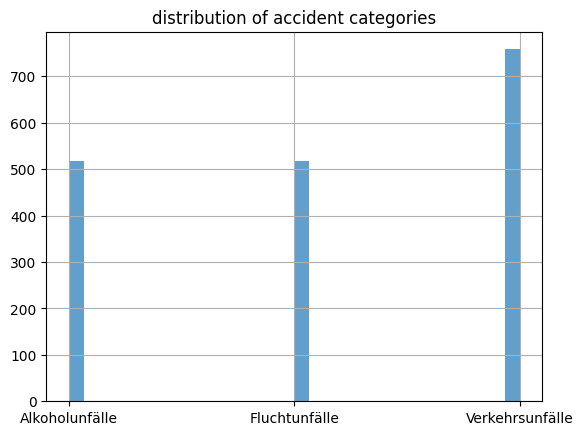

In [93]:
df['MONATSZAHL'].hist(bins=30, alpha=0.7)
plt.title('distribution of accident categories')
plt.show()

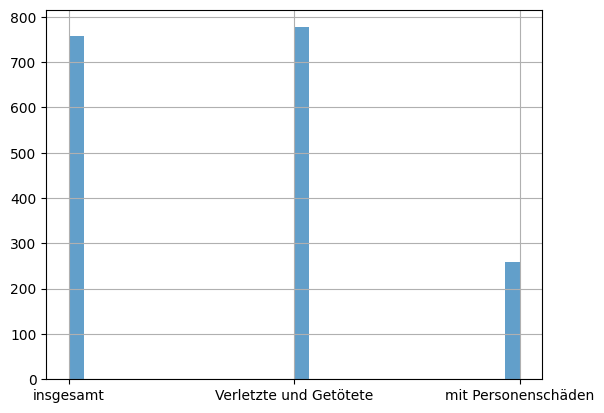

In [94]:
df['AUSPRAEGUNG'].hist(bins=30, alpha=0.7)
plt.show()

# i observed that values are distributed almost uniformly for col JAHR but for column MONAT its a different case

In [95]:
df['JAHR'].value_counts()

,count
JAHR,
2019,90
2018,90
2001,90
2002,90
2003,90
2004,90
2005,90
2006,90
2007,90


In [96]:
df['MONAT'].value_counts()

,count
MONAT,
Summe,114
200901,7
200709,7
200710,7
200711,7
...,...
201201,7
201202,7
201203,7


# Since MONAT includes values like '200703' i.e contains year+month values. We can probly remove the year since we already have that feature in 'JAHR' column. Ill just slice to extract the month values

In [97]:
def convert_date(data, column_name='MONAT', special_value='Summe'):

    day_mapping = {
          '01': 'January',
          '02': 'February',
          '03': 'March',
          '04': 'April',
          '05': 'May',
          '06': 'June',
          '07': 'July',
          '08': 'August',
          '09': 'September',
          '10': 'October',
          '11': 'November',
          '12': 'December'
    }

    data_copy = data.copy()
    data_copy[column_name] = data_copy[column_name].apply(lambda x: day_mapping[x[4:]] if x != special_value else x)

    return data_copy

df = convert_date(df, 'MONAT')

In [98]:
df['MONAT'].unique()

array(['Summe', 'January', 'February', 'March', 'April', 'May', 'June',
       'July', 'August', 'September', 'October', 'November', 'December'],
      dtype=object)

In [99]:
df['MONAT'].value_counts()

,count
MONAT,
January,140
February,140
March,140
April,140
May,140
June,140
July,140
August,140
September,140


# The distribution now seems better for MONAT column

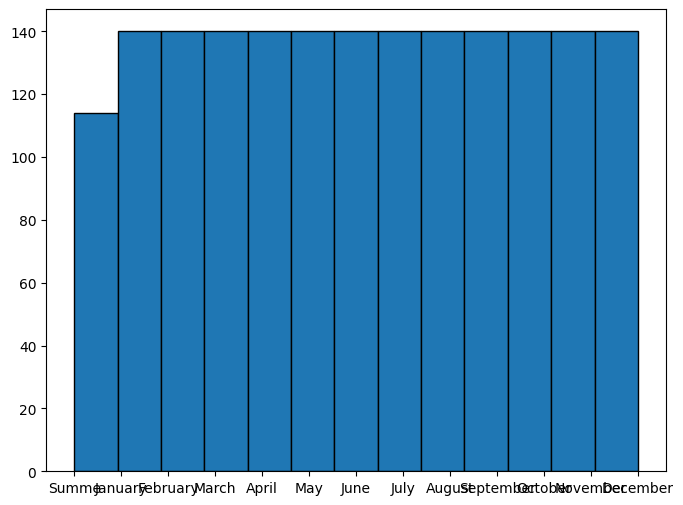

In [100]:
plt.figure(figsize=(8,6))
plt.hist(df['MONAT'], bins=13, edgecolor='black')
plt.show()

In [101]:
df.head(5)

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT
0,Alkoholunfälle,insgesamt,2019,Summe,434.0
1,Alkoholunfälle,insgesamt,2019,January,22.0
2,Alkoholunfälle,insgesamt,2019,February,28.0
3,Alkoholunfälle,insgesamt,2019,March,34.0
4,Alkoholunfälle,insgesamt,2019,April,36.0


# I was confused between using label encoder or one hot encoder, but since the model performed better for one hot encoder, i decided to just go with it

In [102]:
columns_to_encode = df.columns[0:4]

In [105]:
columns_to_encode

Index(['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT'], dtype='object')

In [114]:
def _one_hot(df):
  encoder = OneHotEncoder(sparse_output=False)

  one_hot_columns = df.columns[0:4]

  df_copy = df.copy()

  encoded_columns = encoder.fit_transform(df_copy[one_hot_columns])

  encoded_column_names = encoder.get_feature_names_out(one_hot_columns)

  encoded_df = pd.DataFrame(
    encoded_columns,
    columns=encoded_column_names,
    index=df_copy.index
  )


  final_df = pd.concat([
    df_copy.drop(columns=one_hot_columns),
    encoded_df
  ], axis=1)

  return final_df, encoder

final_df, encoder = _one_hot(df)


In [110]:
final_df.isna().sum()

,0
WERT,0
MONATSZAHL_Alkoholunfälle,0
MONATSZAHL_Fluchtunfälle,0
MONATSZAHL_Verkehrsunfälle,0
AUSPRAEGUNG_Verletzte und Getötete,0
AUSPRAEGUNG_insgesamt,0
AUSPRAEGUNG_mit Personenschäden,0
JAHR_2000,0
JAHR_2001,0
JAHR_2002,0


# 3. finally training the model and downloading it as pkl to use in api

In [77]:
x = final_df.drop(columns=['WERT'])
y = final_df['WERT']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)


In [78]:
xgb = XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    verbosity=2
)


params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8]
}


grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=params,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

Fitting 2 folds for each of 243 candidates, totalling 486 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:56:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:56:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor='gpu_predictor', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_mean_squared_error', verbose=2)

In [79]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on the test set: ", mse)

Mean Squared Error on the test set:  17201.635761885165


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:56:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:56:53] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [112]:
columns_to_encode

Index(['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT'], dtype='object')

In [116]:
def _inference(MONATSZAHL, AUSPRAEGUNG, JAHR, MONAT, encoder, columns_to_encode):

  temp_df = pd.DataFrame({
      'MONATSZAHL': [MONATSZAHL],
      'AUSPRAEGUNG': [AUSPRAEGUNG],
      'JAHR': [JAHR],
      'MONAT': [MONAT]
  })

  temp_df_copy = temp_df.copy()

  processed_df = convert_date(temp_df_copy)

  encoded_columns = encoder.transform(processed_df[columns_to_encode])

  encoded_column_names = encoder.get_feature_names_out(columns_to_encode)

  encoded_df = pd.DataFrame(encoded_columns, columns=encoded_column_names, index=processed_df.index)

  final_df = pd.concat([processed_df.drop(columns=columns_to_encode),encoded_df], axis=1)

  predictions = best_model.predict(final_df)

  return predictions

result = _inference('Alkoholunfälle', 'Verletzte und Getötete', 2012, '201207', encoder, columns_to_encode)


In [119]:
result

array([33.349915], dtype=float32)

# Storing the model & the encoder to be used in our api endpoint

In [118]:
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

with open('encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)